<a href="https://colab.research.google.com/github/fazekas-gergo/composer-ai/blob/master/ComposerAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Composer AI
Authors: Fazekas Gergő and Joseph Tadrous<br>
Used dataset: https://www.kaggle.com/soumikrakshit/classical-music-midi

---
## 1. First steps
At first clone the repository (which also contains the dataset) and install the required packages.

In [31]:
!git clone -l -s https://github.com/fazekas-gergo/composer-ai composer-ai
%cd composer-ai
!pip install midi2audio
!pip install py_midicsv
!pip install pretty_midi
!sudo apt-get install fluidsynth

Cloning into 'composer-ai'...
remote: Enumerating objects: 365, done.
remote: Counting objects: 100% (365/365), done.
remote: Compressing objects: 100% (359/359), done.
remote: Total 365 (delta 21), reused 330 (delta 3), pack-reused 0
Receiving objects: 100% (365/365), 61.18 MiB | 8.57 MiB/s, done.
Resolving deltas: 100% (21/21), done.
/content/composer-ai/composer-ai
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [32]:
import os
import pretty_midi
import collections
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import music21
from sklearn.preprocessing import MinMaxScaler

from midi2audio import FluidSynth
from IPython.display import Audio

---
## 2. Data Familiarization
The *convert_midi_to_flac* function is able to convert the midi file to be listenable by using a soundfont file.

In [33]:
def convert_midi_to_flac(music_path, output='music'):
  FluidSynth('piano.sf2').midi_to_audio(music_path, 'music' + '.flac')
  return 'music' + '.flac'

def play_music(music_path):
  convert_midi_to_flac(music_path, output='music')
  return 'music.flac'

Audio(play_music('classical_music_midi/albeniz/alb_esp1.mid'))

The *music21* package lets us to plot the midi file.

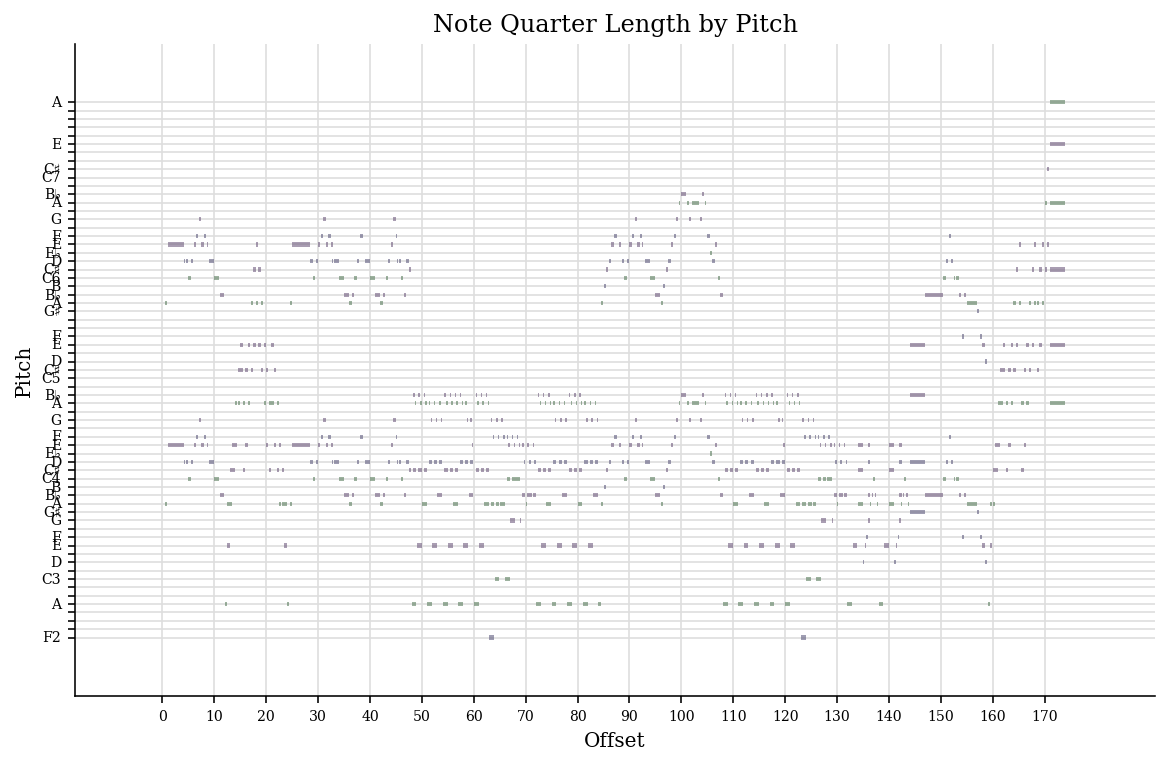

In [34]:
music = music21.converter.parse('classical_music_midi/albeniz/alb_esp1.mid')
music.plot()

---
## 3. Data preparation
At first let's create a list, which contains all the midi files from the dataset.

In [35]:
def get_midi_files(main_folder):
  files = []
  for dir in os.listdir(main_folder):
    for file in os.listdir(main_folder + os.path.sep + dir):
      files.append(main_folder + os.path.sep + dir + os.path.sep + file)
  return files

midi_files = get_midi_files('classical_music_midi')
print('Number of read MIDI files:', len(midi_files))

Number of read MIDI files: 295


Secondly, create a pandas data frame filled with the pitches and durations of the notes sorted by the start time.<br>

In [49]:
def instrument_to_df(instrument):
    notes = collections.defaultdict(list)
    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start
    for note in sorted_notes:
      start = note.start
      end = note.end
      notes['pitch'].append(note.pitch)
      notes['step'].append(start - prev_start)
      notes['duration'].append(end - start)
      prev_start = start
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

def midi_file_to_df(midi_file):
  m = pretty_midi.PrettyMIDI(midi_file)
  return pd.concat([instrument_to_df(instrument) for instrument in m.instruments])

def midi_files_to_df(midi_files):
  return pd.concat([midi_file_to_df(f) for f in midi_files])

df = midi_file_to_df(midi_files[0])
df

pitch      step  duration
0       70  0.000000  0.689814
1       75  0.689814  1.319609
2       63  0.000000  1.319609
3       74  0.645300  0.674309
4       72  0.674309  0.674309
..     ...       ...       ...
440     39  3.831417  2.554278
441     27  0.000000  2.554278
442     63  3.831417  3.831417
443     55  0.000000  3.831417
444     51  0.000000  3.831417

[1171 rows x 3 columns]

In [50]:
df.describe()

pitch         step     duration
count  1171.000000  1171.000000  1171.000000
mean     61.241674     0.460006     1.041884
std      12.644603     0.608790     0.695187
min      24.000000     0.000000     0.164871
25%      51.000000     0.000000     0.559687
50%      63.000000     0.337154     0.791765
75%      72.000000     0.726866     1.379628
max      87.000000     4.740009     4.740009

Remove outliers

In [51]:
df_filtered = df[(df.step < df.step.quantile(.9)) & (df.duration < df.duration.quantile(.9))]
df_filtered.describe()

pitch        step    duration
count  947.000000  947.000000  947.000000
mean    62.470961    0.329222    0.873487
std     12.172299    0.370039    0.421376
min     30.000000    0.000000    0.164871
25%     52.000000    0.000000    0.449236
50%     63.000000    0.322650    0.740924
75%     73.000000    0.674309    1.348618
max     87.000000    1.348618    1.796945

In [52]:
scaler = MinMaxScaler()
scaler.fit(df_filtered)
scaled = scaler.transform(df_filtered)
df_scaled = pd.DataFrame(scaled, columns=['pitch','step','duration'])

df_scaled.describe()

pitch        step    duration
count  947.000000  947.000000  947.000000
mean     0.569666    0.244118    0.434181
std      0.213549    0.274384    0.258184
min      0.000000    0.000000    0.000000
25%      0.385965    0.000000    0.174235
50%      0.578947    0.239245    0.352957
75%      0.754386    0.500000    0.725302
max      1.000000    1.000000    1.000000

Finally, the definition of the **X** (features) and **Y** (targets) matrixes.<br>
The modell has to guess the next note's parameters, therefore we need to shift the **X** matrix with one step.

In [146]:
from numpy.lib.stride_tricks import sliding_window_view
win_len = 32

X = sliding_window_view(df_scaled.drop(df_scaled.tail(1).index), window_shape=(win_len, 3))
X = X.reshape(X.shape[0], X.shape[2], X.shape[3])
Y = df_scaled.drop(range(win_len), axis='index')
X, Y

(array([[[0.70175439, 0.        , 0.32164151],
         [0.78947368, 0.51149695, 0.7075279 ],
         [0.57894737, 0.        , 0.7075279 ],
         ...,
         [0.78947368, 0.        , 0.31683719],
         [0.57894737, 0.        , 0.31683719],
         [0.70175439, 0.50568285, 0.73469395]],
 
        [[0.78947368, 0.51149695, 0.7075279 ],
         [0.57894737, 0.        , 0.7075279 ],
         [0.77192982, 0.47848983, 0.31214133],
         ...,
         [0.57894737, 0.        , 0.31683719],
         [0.70175439, 0.50568285, 0.73469395],
         [0.78947368, 0.        , 0.73469395]],
 
        [[0.57894737, 0.        , 0.7075279 ],
         [0.77192982, 0.47848983, 0.31214133],
         [0.73684211, 0.5       , 0.31214133],
         ...,
         [0.70175439, 0.50568285, 0.73469395],
         [0.78947368, 0.        , 0.73469395],
         [0.57894737, 0.        , 0.73469395]],
 
        ...,
 
        [[0.31578947, 0.        , 0.31683719],
         [0.43859649, 0.50568285, 0.73469

In [147]:
X.shape, Y.shape

((915, 32, 3), (915, 3))



---
# Training


In [81]:
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

In [148]:
model = Sequential([
  LSTM(32, input_shape=(X.shape[1:])),
  Dense(100, activation='relu'),
  Dense(100, activation='relu'),
  Dense(100, activation='relu'),
  Dense(3, activation='softmax', name='output')
])
model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam())
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 32)                4608      
                                                                 
 dense_61 (Dense)            (None, 100)               3300      
                                                                 
 dense_62 (Dense)            (None, 100)               10100     
                                                                 
 dense_63 (Dense)            (None, 100)               10100     
                                                                 
 output (Dense)              (None, 3)                 303       
                                                                 
Total params: 28,411
Trainable params: 28,411
Non-trainable params: 0
_________________________________________________________________


In [144]:
model.get_layer(index=0).input_shape

(None, 2, 3)

In [149]:
es = keras.callbacks.EarlyStopping(patience=5, monitor='loss', restore_best_weights=True, verbose=10)
model.fit(X, Y, epochs=100, callbacks=[es], batch_size=1)

Epoch 1/100
915/915 [==============================] - 7s 6ms/step - loss: 0.0598
Epoch 2/100
915/915 [==============================] - 6s 6ms/step - loss: 0.0567
Epoch 3/100
915/915 [==============================] - 6s 6ms/step - loss: 0.0557
Epoch 4/100
915/915 [==============================] - 6s 6ms/step - loss: 0.0546
Epoch 5/100
915/915 [==============================] - 6s 6ms/step - loss: 0.0533
Epoch 6/100
915/915 [==============================] - 6s 6ms/step - loss: 0.0520
Epoch 7/100
915/915 [==============================] - 6s 6ms/step - loss: 0.0507
Epoch 8/100
915/915 [==============================] - 6s 6ms/step - loss: 0.0507
Epoch 9/100
915/915 [==============================] - 6s 6ms/step - loss: 0.0495
Epoch 10/100
915/915 [==============================] - 6s 6ms/step - loss: 0.0489
Epoch 11/100
915/915 [==============================] - 6s 6ms/step - loss: 0.0487
Epoch 12/100
915/915 [==============================] - 6s 6ms/step - loss: 0.0484
Epoch 13/100




---
# Output
Write output into a midi file and listen it


In [185]:
def predict(num: int):
  preds = np.zeros(shape=(num, 3))
  for i in range(num-win_len):
    input = preds[i:i+win_len].reshape(win_len, 3)
    new_pred = model.predict(preds[i:i+win_len].reshape(1, win_len, 3)).reshape(3)
    preds[i+win_len] = new_pred
  print(preds)
  return scaler.inverse_transform(preds.reshape(-1, 3))

predictions = predict(64)
predictions = pd.DataFrame(predictions, columns=['pitch',	'step',	'duration'])
predictions

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.  

pitch      step  duration
0   30.000000  0.000000  0.164871
1   30.000000  0.000000  0.164871
2   30.000000  0.000000  0.164871
3   30.000000  0.000000  0.164871
4   30.000000  0.000000  0.164871
..        ...       ...       ...
59  51.628721  0.547606  0.514949
60  51.406277  0.557317  0.509566
61  51.504831  0.579826  0.479505
62  41.030662  0.831059  0.475372
63  50.093356  0.569281  0.532680

[64 rows x 3 columns]

In [186]:
music = pretty_midi.PrettyMIDI()
piano = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program('Acoustic Grand Piano'))

start = 0
for index, p in predictions.iterrows():
  note_number = round(p.pitch)
  note = pretty_midi.Note(velocity=100, pitch=note_number, 
                          start=start, end=start+p.duration)
  piano.notes.append(note)
  start += p.step

# Add the piano instrument to the PrettyMIDI object
music.instruments.append(piano)
# Write out the MIDI data
music.write('output.mid')

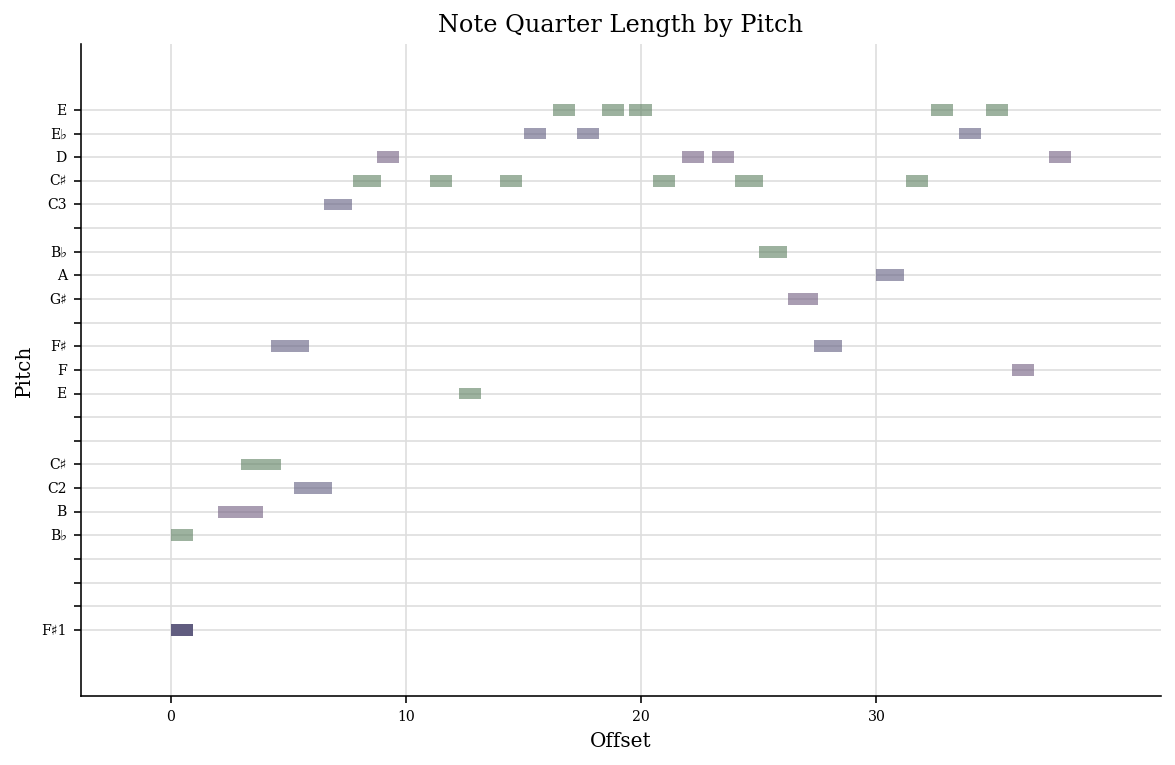

In [187]:
music = music21.converter.parse('output.mid')
music.plot()

In [188]:
Audio(play_music('output.mid'))